In [1]:
import json
import uproot
import numpy as np
import pickle as pkl
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# single jet
#ntuple_path  = '/Users/ets/Dropbox/WIS/PFlow/samples/Ntuples_singleJet_noID_SuperResCosh_noThetaPhiSmearing_oldQPsmearing_18102022/test_skim.root'
# ttbar
ntuple_path      = '/Users/ets/Dropbox/WIS/PFlow/samples/Ntuples_ttbar_noID_SuperResCosh_21062022/val.root'

In [3]:
f = uproot.open(ntuple_path)
# [x for x in f['Low_Tree'].keys() if 'jet' in x]

# Helper classes/functions

In [4]:
class TrackHelix(object):
    
    '''
    Taken from
    https://github.com/wisroma-pflow/SCD/blob/main/event_display/source_py/track_utils.py#L9
    '''
    
    def __init__(self,d0,z0,theta,phi0,qoverp):
        
        self.theta = theta
        self.phi0 = phi0
        self.d0 = d0
        self.z0 = z0
        self.vx = 0
        self.vy = 0
        self.vz = 0
        self.qoverp = qoverp
        self.Bz = 3.8
        
        self.rho = ( (np.sin(self.theta))/(self.qoverp*self.Bz) )*(1.0/0.299792)
        
    #parametrisation of helix, starting from perigee point
    def x_of_phi(self,phi):
        return self.vx+self.d0*np.cos(self.phi0+np.pi/2.0)+self.rho*(np.cos(phi+np.pi/2)-np.cos(self.phi0+np.pi/2))
    def y_of_phi(self,phi):
        return self.vy+self.d0*np.sin(self.phi0+np.pi/2.0)+self.rho*(np.sin(phi+np.pi/2)-np.sin(self.phi0+np.pi/2))
    def z_of_phi(self,phi):
        return self.vz+self.z0-(self.rho)*(1.0/np.tan(self.theta))*(phi-self.phi0)

def get_track_traj(d0, z0, theta, phi0, qoverp):

    '''
    Taken from
    https://github.com/wisroma-pflow/SCD/blob/main/event_display/source_py/track_utils.py#L44
    '''

    track = TrackHelix(d0,z0,theta,phi0,qoverp)

    phis = np.linspace(phi0,phi0-np.sign(qoverp)*np.pi*1.0,550)
    
    xs = np.array([track.x_of_phi(phi) for phi in phis])
    ys = np.array([track.y_of_phi(phi) for phi in phis])
    zs = np.array([track.z_of_phi(phi) for phi in phis])
    
    rs = np.sqrt( xs**2+ys**2 )

    stop_idx = np.where(rs >1500)[0]

    if len(stop_idx) > 0:
        stop_idx = stop_idx[0]

    else:
        return []

    traj = np.column_stack([xs[:stop_idx],ys[:stop_idx],zs[:stop_idx]])
    traj = traj.tolist()
    
    return traj

def get_topoclusters(cell_topo_idx, cell_eta, cell_phi, cell_e):
    
    n_topoclusters = max(cell_topo_idx)

    topoclusters = []
    for i in range(n_topoclusters):
        mask = cell_topo_idx == i+1
        
        tmp_e = cell_e[mask].sum()
        tmp_eta = (cell_eta * cell_e)[mask].sum() / tmp_e
        tmp_phi = (cell_phi * cell_e)[mask].sum() / tmp_e

        tmp_tc = {
            'energy': tmp_e.item(),
            'eta'   : tmp_eta.item(),
            'phi'   : tmp_phi.item()
        }
        
        topoclusters.append(tmp_tc)
        
    return topoclusters

def get_cells(cell_x, cell_y, cell_z, cell_e):
    
    cells = []
    
    for i,x in enumerate(cell_x):
        size = np.log(cell_e[i].item())*5
        cells.append({
            'type': 'Point',
            'pos': [cell_x[i].item(),cell_y[i].item(),cell_z[i].item()], #,size,size,size],
            #'x': cell_x[i].item(),
            #'y': cell_y[i].item(),
            #'z': cell_z[i].item(),
            'color': '#FFFF00', #yellow
        })
        
    return cells

def energy_transparency(cell_e):
    
    return (np.log(cell_e) - np.min(np.log(cell_e)))/np.ptp(np.log(cell_e))

def get_color(layer,scaleby):

#     lay_max = np.array([
#                         [0, 255, 128],
#                         [0, 255, 128],
#                         [0, 255, 128],
#                         [127, 0, 255],
#                         [127, 0, 255],
#                         [127, 0, 255]
#                        ])
    
    lay_max = np.array([[110, 222, 138],
                        [146, 230, 167],
                        [183, 239, 197],
                        [129, 137, 255],
                        [150, 162, 255],
                        [174, 184, 255]
                       ])
    
    rgb = lay_max[layer]
    rgb = rgb*scaleby
    rgb = np.clip(rgb,0,255).astype(int)
    
    return f"rgb({rgb[0]}, {rgb[1]}, {rgb[2]})"

def get_vertices(cell_x, cell_y, cell_z, cell_l, cell_e, vertices_df, dump_vertices=False, dump_centres=False):
    
    merge_supercells = True
    size = 0.2
    vertices = []
    hashlist = []
    distlist = []
    #colors   = [0x6ede8a,0x92e6a7,0xb7efc5,0x8189ff,0x96a2ff,0xaeb8ff]
    colors   = ["rgb(110, 222, 138)","rgb(146, 230, 167)","rgb(183, 239, 197)","rgb(129, 137, 255)","rgb(150, 162, 255)","rgb(174, 184, 255)"]
    layer_noise = [13, 34.,41.,75.,50.,25.]
    
    energy_01 = (np.log(cell_e) - np.min(np.log(cell_e)))/np.ptp(np.log(cell_e))
    
    print(min(energy_01))
    print(max(energy_01))

    event_cells = np.column_stack([cell_x,cell_y,cell_z])
    
    for idx, cell in enumerate(tqdm(event_cells)):
        #if idx>5: continue #HACK!
        #if(cell_l[idx])!=0:
        #    continue
        layer_df = vertices_df[vertices_df['layer']==cell_l[idx]]
        if len(layer_df) == 0: continue
        mpos = np.column_stack([layer_df['vmx'].to_numpy(),layer_df['vmy'].to_numpy(),layer_df['vmz'].to_numpy()])
        pos  = np.repeat(np.expand_dims(cell,axis=0),len(mpos),axis=0)
        dist = np.linalg.norm(pos - mpos,axis=1)

        if(len(dist)==0):
            print(layer_df)
            print('cell_l=',cell_l[idx])
        i_min = np.argmin(dist)
        #if dist[i_min]>5:
        #    continue
            
        distlist.append(dist[i_min])
        winner = layer_df.iloc[i_min]['hash'].item()
        if winner in hashlist:
            print('WARNING: found duplicate! hash=',winner)
            continue
        hashlist.append(winner)
        #print('winner = ', winner)
        #row   = layer_df.iloc[i_min]
        rows   = layer_df[layer_df['hash']==winner]
        rows   = rows.sort_values('eta_idx')
        #rows   = layer_df[(layer_df['region']==2) & (layer_df['v7y']>0) & (layer_df['v0x']>0)] #HACK!
        #print(rows)

    
        if merge_supercells and not dump_vertices and not dump_centres:
        
            flat_coords = []
            
            if len(rows)>1:
                vlists = [
                    [0,2,4,6],
                    [1,3,5,7],
                ]

                first_and_last = [0,len(rows)-1] if len(rows)>1 else [0]

                for idx,subcell in enumerate(first_and_last):
                    row = rows.iloc[subcell]
                    for v in vlists[idx]:
                        flat_coords = flat_coords + [row['v{}x'.format(v)].item(),row['v{}y'.format(v)].item(),row['v{}z'.format(v)].item()]
            else:
                row = rows
                for v in range(8):
                    flat_coords = flat_coords + [row['v{}x'.format(v)].item(),row['v{}y'.format(v)].item(),row['v{}z'.format(v)].item()]                
            

            layer = int(row['layer'].item())
            energy = cell_e[idx].item()
            #if layer > 2:
            #    layer = layer - 1
            vertices.append({
                'type': 'SCDCaloCells',
                'layer': layer,
                'energy': energy,
                'vtx': flat_coords,
                'color': get_color(layer,1. ),# energy_01[idx]), #colors[layer],
                'opacity': energy_01[idx].item(),
            })
        else:

            for _, row in rows.iterrows():
            #for _ in range(1):

                if dump_centres: #dump the geometric centre of each cell as a point to display as a hit
                    v = 'm'
                    vertices.append({
                        'type': 'Point',
                        'pos': [row['v{}x'.format(v)].item(),row['v{}y'.format(v)].item(),row['v{}z'.format(v)].item()],
                        'color': '#FFFF00', #yellow
                    })
                elif dump_vertices: #dump each vertex as a separate point to display as a hit
                    for v in range(8):
                        vertices.append({
                            'type': 'Point',
                            'pos': [row['v{}x'.format(v)].item(),row['v{}y'.format(v)].item(),row['v{}z'.format(v)].item()],
                            'color': '#FFFF00', #yellow
                        })
                else: #dump full coords per cell as a polyhedron to display as an SCD cell
                    flat_coords = []
                    vlist = range(8)
                    for v in vlist:
                        flat_coords = flat_coords + [row['v{}x'.format(v)].item(),row['v{}y'.format(v)].item(),row['v{}z'.format(v)].item()]

                    layer = int(row['layer'].item())
                    energy = cell_e[idx].item()
                    #if layer > 2:
                    #    layer = layer - 1
                    vertices.append({
                        'type': 'SCDCaloCells',
                        'layer': layer,
                        'energy': energy,
                        'vtx': flat_coords,
                        'color': colors[layer],
                        'opacity': energy_01[idx].item(),
                    })


    #plt.hist(distlist,bins=100)
    #return vertices[0:2] #HACK!
    #print(hashlist)
    return vertices
        

# temporary hack
# linear scaling 
#     20_00, 300_000 -> 15_000, 40_000

def get_scaled_jet_e(e):
    x_, y_ = 20_000, 300_000
    x,  y  = 25_000,  40_000
    
    scale = (y - x) / (y_ - x_)
    scaled_e = (e - x_) * scale + x
    
    return scaled_e

In [5]:
# def dumpdata(ntuple_path,nevents=1):
    
#     tree = uproot.open(ntuple_path)['Low_Tree']
#     nevents = min(tree.num_entries, nevents)   
    
#     #cells
#     cell_x   = tree["cell_x"].array(library='np', entry_stop=nevents)    
#     cell_y   = tree["cell_y"].array(library='np', entry_stop=nevents)    
#     cell_z   = tree["cell_z"].array(library='np', entry_stop=nevents)
#     cell_l   = tree["cell_layer"].array(library='np', entry_stop=nevents)    
#     cell_eta = tree["cell_eta"].array(library='np', entry_stop=nevents)    
#     cell_phi = tree["cell_phi"].array(library='np', entry_stop=nevents)    
#     cell_e = tree["cell_e"].array(library='np', entry_stop=nevents)    


In [6]:
def scd2phdata(ntuple_path, output_path, nevents=1):
    
    tree = uproot.open(ntuple_path)['Low_Tree']
    nevents = min(tree.num_entries, nevents)   
    
    # tracks
    track_d0 = tree["track_d0"].array(library='np', entry_stop=nevents)
    track_z0 = tree["track_z0"].array(library='np', entry_stop=nevents)
    track_theta = tree["track_theta"].array(library='np', entry_stop=nevents)
    track_phi = tree["track_phi"].array(library='np', entry_stop=nevents)
    track_qoverp = tree["track_qoverp"].array(library='np', entry_stop=nevents)
    track_pdgid = tree["track_pdgid"].array(library='np', entry_stop=nevents)    
    
    # topoclusters
    cell_topo_idx = tree["cell_topo_idx"].array(library='np', entry_stop=nevents)
    
    #cells
    cell_x   = tree["cell_x"].array(library='np', entry_stop=nevents)    
    cell_y   = tree["cell_y"].array(library='np', entry_stop=nevents)    
    cell_z   = tree["cell_z"].array(library='np', entry_stop=nevents)
    cell_l   = tree["cell_layer"].array(library='np', entry_stop=nevents)    
    cell_eta = tree["cell_eta"].array(library='np', entry_stop=nevents)    
    cell_phi = tree["cell_phi"].array(library='np', entry_stop=nevents)    
    cell_e = tree["cell_e"].array(library='np', entry_stop=nevents)    
    
    # jets
    true_jet_pt  = tree["true_jet_pt"].array(library='np', entry_stop=nevents)
    true_jet_eta = tree["true_jet_eta"].array(library='np', entry_stop=nevents)
    true_jet_phi = tree["true_jet_phi"].array(library='np', entry_stop=nevents)
    true_jet_m   = tree["true_jet_m"].array(library='np', entry_stop=nevents)

    pflow_jet_pt  = tree["pflow_jet_pt"].array(library='np', entry_stop=nevents)
    pflow_jet_eta = tree["pflow_jet_eta"].array(library='np', entry_stop=nevents)
    pflow_jet_phi = tree["pflow_jet_phi"].array(library='np', entry_stop=nevents)
    pflow_jet_m   = tree["pflow_jet_m"].array(library='np', entry_stop=nevents)


    event_data = {}
    
    for i in range(nevents):
                
        event_dict = dict()
        
        event_dict['event number']: i
        event_dict['run number']  : 0

            
        #    
        # tracks
        #------------------
        
        n_tracks = track_d0[i].shape[0]
        
        tracks = {}
        all_tracks = []
        e_tracks = []; chhad_tracks = []; mu_tracks = []

        for j in range(n_tracks):
            track_traj = get_track_traj(
                    track_d0[i][j], track_z0[i][j], track_theta[i][j], track_phi[i][j], track_qoverp[i][j])

            tmp_track = {
                'pos': track_traj,
                'color': '0xff0000'
            }
            all_tracks.append(tmp_track)
            
            if track_pdgid[i][j] in [11, -11]:
                tmp_track = {
                    'pos': track_traj,
                    'color': '0xff8700'
                }
                e_tracks.append(tmp_track)

            elif track_pdgid[i][j] in [13, -13]:
                tmp_track = {
                    'pos': track_traj,
                    'color': '0xffd100'
                }
                mu_tracks.append(tmp_track)

            else:
                tmp_track = {
                    'pos': track_traj,
                    'color': '0xff5d00'
                }
                chhad_tracks.append(tmp_track)

        tracks['all_tracks']   = all_tracks
        tracks['e_tracks']     = e_tracks
        tracks['chhad_tracks'] = chhad_tracks
        tracks['mu_tracks']    = mu_tracks

        event_dict['Tracks'] = tracks
        
                
        #    
        # jets
        #------------------           

        jets = {}

        n_true_jets = true_jet_pt[i].shape[0]
        true_jets = []

        for j in range(n_true_jets):
            jet_p = true_jet_pt[i][j] * np.cosh(true_jet_eta[i][j])   
            jet_e = np.sqrt(true_jet_m[i][j] **2 + jet_p **2)
            
            tmp_jet = {
                'eta': true_jet_eta[i][j].item(),
                'phi': true_jet_phi[i][j].item(),
                'coneR': 0.4,
                'energy': get_scaled_jet_e(jet_e.item()),
#                     'color': '0x72fcfc'
            }
            true_jets.append(tmp_jet)
        jets['truth jets'] = true_jets
            
            
#         n_pflow_jets = pflow_jet_pt[i].shape[0]
#         pflow_jets = []
        
#         for j in range(n_pflow_jets):
#             jet_p = pflow_jet_pt[i][j] * np.cosh(pflow_jet_eta[i][j])   
#             jet_e = np.sqrt(pflow_jet_m[i][j] **2 + jet_p **2)

#             if jet_e > 20_000:
#                 tmp_jet = {
#                     'eta': pflow_jet_eta[i][j].item(),
#                     'phi': pflow_jet_phi[i][j].item(),
#                     'coneR': 0.4,
#                     'energy': jet_e.item(),
# #                     'color': '0x81d5fc'
#                 }
#                 pflow_jets.append(tmp_jet)
#         jets['pflow jets'] = pflow_jets
        
        event_dict['Jets'] = jets
        
        
                
        #    
        # calclusters
        #------------------
        
        calo_clusters = {}
        calo_clusters['topoclusters'] = get_topoclusters(cell_topo_idx[i], cell_eta[i], cell_phi[i], cell_e[i])        
        event_dict['CaloClusters'] = calo_clusters

        #
        # hits
        #------------------
        
        cells = {}
        cells['hits'] = get_cells(cell_x[i],cell_y[i],cell_z[i],cell_e[i])
        #event_dict['Hits'] = cells
        
        #
        # cells
        #------------------
        
        #cells = {}
        cells['centres'] = get_vertices(cell_x[i],cell_y[i],cell_z[i],cell_l[i],cell_e[i],cell_df,dump_centres=True)
        event_dict['Hits'] = cells

        
        #
        # SCDCaloCells
        #------------------
        
        scc = {}
        scc['vertices'] = get_vertices(cell_x[i],cell_y[i],cell_z[i],cell_l[i],cell_e[i],cell_df)
        event_dict['SCDCaloCells'] = scc
        
        
        # event
        event_data[f'event_num_{i}'] = event_dict
        
    json_object = json.dumps(event_data, indent=2)
    with open(output_path, "w") as outfile:
        outfile.write(json_object)


### Retrieve map of cells

In [7]:
cell_path = "cells.pkl"
cell_df   = pkl.load(open(cell_path,'rb'))
cell_df

,v0x,v0y,v0z,v1x,v1y,v1z,v2x,v2y,v2z,v3x,...,v6z,v7x,v7y,v7z,layer,region,eta_idx,phi_idx,hash,idx
0,0.000000,318.822026,3193.919183,0.000000,326.421600,3193.919183,0.000000,328.169777,3287.563786,0.000000,...,3287.563786,-8.245661e+00,335.890973,3287.563786,0,1,0,1,100001,0
0,0.000000,318.822026,-3193.919183,0.000000,326.421600,-3193.919183,0.000000,328.169777,-3287.563786,0.000000,...,-3287.563786,-8.245661e+00,335.890973,-3287.563786,0,-1,0,1,-100001,1
0,-7.824284,318.726003,3193.919183,-8.010787,326.323287,3193.919183,-8.053690,328.070939,3287.563786,-8.245661,...,3287.563786,-1.648635e+01,335.587450,3287.563786,0,1,0,2,100002,2
0,-7.824284,318.726003,-3193.919183,-8.010787,326.323287,-3193.919183,-8.053690,328.070939,-3287.563786,-8.245661,...,-3287.563786,-1.648635e+01,335.587450,-3287.563786,0,-1,0,2,-100002,3
0,-15.643855,318.437991,3193.919183,-16.016749,326.028410,3193.919183,-16.102528,327.774483,3287.563786,-16.486354,...,3287.563786,-2.471712e+01,335.081782,3287.563786,0,1,0,3,100003,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1336.441351,2000.125827,-4990.814229,1336.441351,2000.125827,-5122.047479,1451.810742,2172.788323,-5421.650345,1451.810742,...,-5421.650345,1.000025e+03,2414.273030,-5564.212412,6,-2,7,30,-267030,204795
0,920.556813,2222.420744,4990.814229,920.556813,2222.420744,5122.047479,1000.024632,2414.273030,5421.650345,1000.024632,...,5421.650345,5.098081e+02,2562.978579,5564.212412,6,2,7,31,267031,204796
0,920.556813,2222.420744,-4990.814229,920.556813,2222.420744,-5122.047479,1000.024632,2414.273030,-5421.650345,1000.024632,...,-5421.650345,5.098081e+02,2562.978579,-5564.212412,6,-2,7,31,-267031,204797
0,469.295794,2359.309278,4990.814229,469.295794,2359.309278,5122.047479,509.808137,2562.978579,5421.650345,509.808137,...,5421.650345,1.477929e-12,2613.190297,5564.212412,6,2,7,32,267032,204798


In [8]:
print([np.sum(cell_df['layer']==i) for i in range(6)])

[65536, 65536, 32768, 0, 16384, 16384]


In [9]:
#for r in range(1000):
#    print(cell_df[cell_df['layer']==5].iloc[r]['hash'])

In [10]:
#Make up for iron gap <-- already converted upstream
cell_df.loc[ cell_df['layer']==4, 'layer'] = 3
cell_df.loc[ cell_df['layer']==5, 'layer'] = 4
cell_df.loc[ cell_df['layer']==6, 'layer'] = 5

cell_df['vmx'] = np.mean(np.column_stack([cell_df['v{}x'.format(i)].to_numpy() for i in range(8)]),axis=1)
cell_df['vmy'] = np.mean(np.column_stack([cell_df['v{}y'.format(i)].to_numpy() for i in range(8)]),axis=1)
cell_df['vmz'] = np.mean(np.column_stack([cell_df['v{}z'.format(i)].to_numpy() for i in range(8)]),axis=1)

In [11]:
print(max(cell_df['layer']))

5


In [12]:
idx = 10
Nv = 8

#cell_df = cell_df[cell_df['layer']==6]
#cell_df = cell_df[0:2]
#print(cell_df)

new_dict = {
    'x': pd.concat([cell_df['v{}x'.format(i)] for i in range(Nv)]),
    'y': pd.concat([cell_df['v{}y'.format(i)] for i in range(Nv)]),
    'z': pd.concat([cell_df['v{}z'.format(i)] for i in range(Nv)]),
    'idx': pd.concat([cell_df['idx'] for i in range(Nv)]),
    'layer': pd.concat([cell_df['layer'] for i in range(Nv)]),
    'corner': np.repeat([range(Nv)],len(cell_df),axis=0).flatten().tolist()
           }
new_df = pd.DataFrame(new_dict)
#px.line_3d(new_df,x='z',y='y',z='x',color='corner')
#px.scatter_3d(new_df,x='z',y='y',z='x',color='corner')
#px.scatter_3d(cell_df,x='v0z',y='v0y',z='v0x')

fig = go.Figure(data=[go.Scatter3d(
    #x=new_dict['x'],y=new_dict['y'],z=new_dict['z'],
    x=cell_df['vmx'],y=cell_df['vmy'],z=cell_df['vmz'],
    mode='markers',
    marker=dict(
        size=3,
        color=new_dict['layer'],#np.linalg.norm(np.column_stack([new_dict['x'],new_dict['y'],new_dict['z']]),axis=1),    # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.write_html("cells.html")

In [18]:
output_path = 'events.json'
scd2phdata(ntuple_path, output_path, 10)

0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2120/2120 [00:11<00:00, 183.63it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2120/2120 [00:12<00:00, 168.90it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1492/1492 [00:08<00:00, 183.42it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1492/1492 [00:08<00:00, 171.85it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4510/4510 [00:23<00:00, 195.60it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4510/4510 [00:24<00:00, 182.39it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3121/3121 [00:16<00:00, 191.79it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3121/3121 [00:16<00:00, 183.94it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3992/3992 [00:20<00:00, 191.58it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3992/3992 [00:22<00:00, 179.60it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1899/1899 [00:10<00:00, 184.67it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1899/1899 [00:10<00:00, 174.23it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2424/2424 [00:12<00:00, 194.85it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2424/2424 [00:13<00:00, 181.04it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1892/1892 [00:10<00:00, 186.15it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1892/1892 [00:10<00:00, 176.91it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1346/1346 [00:07<00:00, 189.00it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1346/1346 [00:07<00:00, 179.42it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:09<00:00, 187.94it/s]


0.0
1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:10<00:00, 176.50it/s]


In [14]:
with open(output_path, 'r') as fj:
    data = json.load(fj)
#     print(json.dumps(data, indent=2, sort_keys=True))

In [15]:
tree = uproot.open(ntuple_path)['Low_Tree']
nevents = 5
cell_e = tree["cell_e"].array(library='np', entry_stop=nevents)[0]

In [16]:
cell_e_transformed = (np.log(cell_e) - np.min(np.log(cell_e)))/np.ptp(np.log(cell_e))

(array([  1.,   1.,   5.,  33., 227., 804., 795., 202.,  43.,   9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

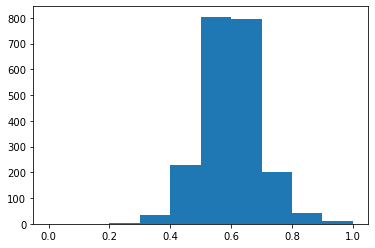

In [17]:
plt.hist(cell_e_transformed)